# Transform orbits to cartesian

In [45]:
import numpy as np
import h5py as h5
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt

import pickle
pickle.HIGHEST_PROTOCOL = 4

import pandas as pd
import os.path

import pyoorb as oo

In [2]:
oo.pyoorb.oorb_init()

0

[How to define orbits](https://github.com/oorb/oorb/blob/master/python/README.rst#defining-orbits)

In [3]:
element_types = ["CART", "COM", "KEP"]

## Try for S3M

In [4]:
s3m_df = pd.read_hdf("catalogues/s3m.h5", key="df")

In [5]:
s3m_orbits = np.array(
    np.array([
        np.linspace(0, len(s3m_df) - 1, len(s3m_df)),
        s3m_df.q,
        s3m_df.e,
        np.deg2rad(s3m_df.i),
        np.deg2rad(s3m_df.Omega),
        np.deg2rad(s3m_df.argperi),
        s3m_df.t_p,
        np.repeat(element_types.index("COM") + 1, len(s3m_df)).astype(int),
        s3m_df.t_0,
        np.repeat(3, len(s3m_df)).astype(int),
        s3m_df.H,
        np.repeat(0.15, len(s3m_df))
    ]).transpose(),
dtype=np.double, order='F')

In [6]:
s3m_cart_orbits, error = oo.pyoorb.oorb_element_transformation(in_orbits=s3m_orbits, in_element_type=1)

In [7]:
print(error)

0


## Try for MPCORB

In [8]:
mpcorb_df = pd.read_hdf("catalogues/mpcorb.h5", key="df")

In [9]:
mpcorb_orbits = np.array(
    np.array([
        np.linspace(0, len(mpcorb_df) - 1, len(mpcorb_df)),
        mpcorb_df.a,
        mpcorb_df.e,
        np.deg2rad(mpcorb_df.i),
        np.deg2rad(mpcorb_df.Omega),
        np.deg2rad(mpcorb_df.arg_peri),
        np.deg2rad(mpcorb_df.mean_anom),
        np.repeat(element_types.index("KEP") + 1, len(mpcorb_df)).astype(int),
        mpcorb_df.epoch,
        np.repeat(3, len(mpcorb_df)).astype(int),
        mpcorb_df.H,
        mpcorb_df.G
    ]).transpose(),
dtype=np.double, order='F')

In [10]:
mpcorb_cart_orbits, error = oo.pyoorb.oorb_element_transformation(in_orbits=mpcorb_orbits, in_element_type=1)

In [12]:
error

0

array(['S0000001a', 'S0000002a', 'S0000003a', ..., 'STR001z1a',
       'STR001z2a', 'STR001z3a'], dtype=object)

# Orbit Propagation

Propagate **both** to December 1st

In [13]:
dec_first = Time("2020-12-01").mjd

In [14]:
mpcorb_prop_orbits, error = oo.pyoorb.oorb_propagation(in_orbits=mpcorb_cart_orbits,
                                                       in_epoch=np.array([dec_first, 3],
                                                                         dtype=np.double, order='F'),
                                                       in_dynmodel="2")

In [47]:
mpcorb_ready = pd.DataFrame(mpcorb_prop_orbits, columns=["id", "x", "y", "z", "vx", "vy", "vz",
                                                         "coords", "epoch", "time_type", "H", "g"])
mpcorb_ready = mpcorb_ready[["id", "x", "y", "z", "vx", "vy", "vz", "H", "g"]]
mpcorb_ready["def"] = mpcorb_df["des"].values
mpcorb_ready.to_hdf("catalogues/mpcorb_propagated.h5", key="df", mode="w")

In [15]:
s3m_prop_orbits, error = oo.pyoorb.oorb_propagation(in_orbits=s3m_cart_orbits,
                                                    in_epoch=np.array([dec_first, 3],
                                                                      dtype=np.double, order='F'),
                                                    in_dynmodel="2")

In [46]:
s3m_ready = pd.DataFrame(s3m_prop_orbits, columns=["id", "x", "y", "z", "vx", "vy", "vz",
                                                   "coords", "epoch", "time_type", "H", "g"])
s3m_ready = s3m_ready[["id", "x", "y", "z", "vx", "vy", "vz", "H", "g"]]
s3m_ready["des"] = s3m_df.index.values
s3m_ready.to_hdf("catalogues/s3m_propagated.h5", key="df", mode="w")

In [62]:
# my default code plot for making plots look nice
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [51]:
from matplotlib.ticker import MultipleLocator

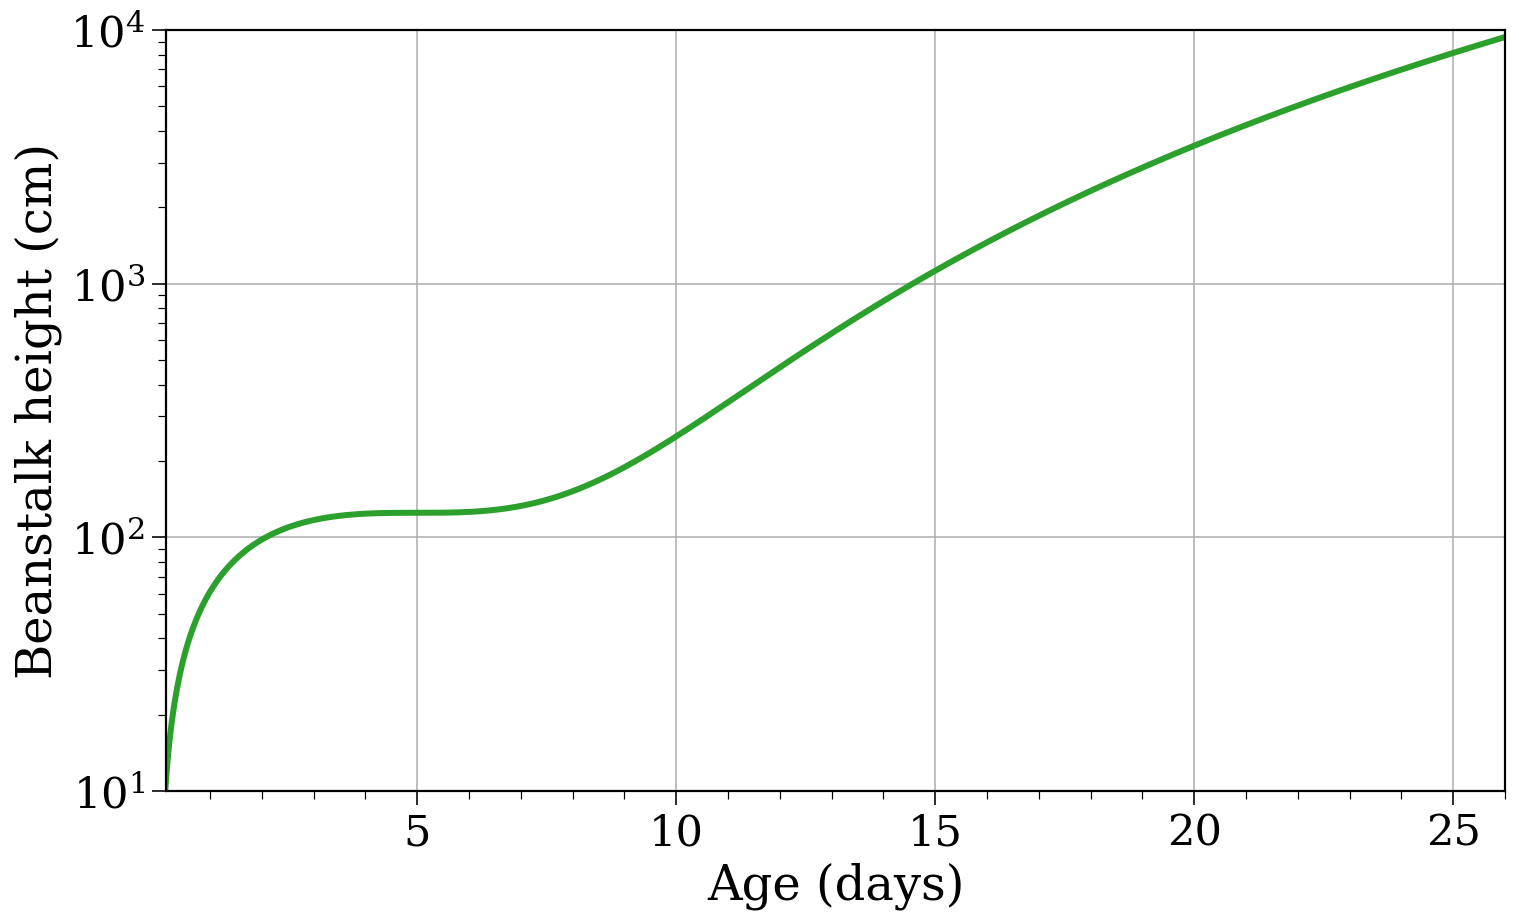

In [66]:
def func(x):
    return (x - 5)**3 + 125

x_range = np.linspace(0, 26, 1000)

fig, ax = plt.subplots(figsize=(12, 7))

plt.plot(x_range, func(x_range), color="tab:green", lw=3)

ax.set_yscale("log")
ax.set_xlim(0.15, 26)
ax.set_ylim(1e1, 1e4)

ax.set_xlabel("Age (days)")
ax.set_ylabel("Beanstalk height (cm)")

ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.grid()

plt.show()